In [ ]:
from IPython.display import HTML
from vevestaX import vevesta as v
from IPython.display import display, HTML
from PIL import Image
from dask.distributed import Client
from dask.distributed import as_completed
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from pandas.io.formats.style import Styler
from pivottablejs import pivot_ui
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
import pyfolio as pf
from random import sample
import scipy.stats as st
import scipy
from itertools import combinations
from scipy import stats
import random
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression


# use automatically configured elastic net algorithm
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold


from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import re
from statsmodels.stats.outliers_influence import summary_table
import datetime as dt
import matplotlib
import matplotlib as mp
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_market_calendars as mcal
import pickle
import rpy2
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import statsmodels
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
import rpy2
import rpy2.robjects as ro
import time
from clustergram import Clustergram
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.vq import vq
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale
from k_means_constrained import KMeansConstrained
from scipy.stats import f as f_
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML as html_print
from IPython.display import display
import statsmodels.formula.api as smf



from itertools import permutations 
  
# univariate bidirectional lstm example
from numpy import array

"""
from tensorflow.keras.layers import Input, Multiply
from tensorflow.keras.models import Model
"""

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_logical_devices('GPU')

pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

import pandas as pd
from rpy2.robjects import pandas2ri
from prophet import Prophet
from multi_prophet.multi_prophet import MultiProphet

from statsmodels.tsa.statespace.varmax import VARMAX
import joblib

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
"""
# split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
"""

In [ ]:
def convert_dates(ds):
    date = pd.to_datetime(ds)
    return(date)

In [ ]:
def format_vertical_headers(df):
    """Display a dataframe with vertical column headers"""
    styles = [dict(selector="th", props=[('width', '40px')]),
              dict(selector="th.col_heading",
                   props=[("writing-mode", "vertical-rl"),
                          ('transform', 'rotateZ(180deg)'), 
                          ('height', '290px'),
                          ('vertical-align', 'top')])]
    return (df.fillna('').style.set_table_styles(styles))

In [ ]:
#if not sys.warnoptions:
#    import warnings
#    warnings.simplefilter("ignore")

wd = os.getcwd()

if (os.defpath==".;C:\\bin"):
    os.environ['R_HOME'] = 'C:/Users/User/Documents/R/R-4.1.2'
    os.environ['R_LIBS'] = 'C:/Users/User/Documents/R/R-4.1.2/library'
    from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
else:
    os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'

pandas2ri.activate()


In [ ]:

#robjects.ro['version']

base = importr('base')
#grdevices = importr('grDevices')
print(base._libPaths())

timetk = importr('timetk')
magrittr = importr('magrittr')
dplyr = importr('dplyr')
tidyverse = importr('tidyverse')
nbclust = importr('NbClust')
grdevices = importr('grDevices')


In [ ]:
si = ['03-31','06-30','09-30','12-31']

#future_commodities_n_w_index_pvt_w_Fred is fred index's and not futures merged with futures data
#future_commodities_n_w_index_pvt_w_Fred = pd.read_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_future_commodities_n_w_index_pvt_w_Fred.csv')
#[start,end,prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted, dict_sectors, dict_indexes, dict_sectors_reverse, invert_dict_indexes, list_sector_n_indexes, list_stocks] = pickle.load(open('..\\data\\interim\\data_object.pkl', 'rb'))
[start,end,prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted, dict_sectors, dict_indexes, dict_sectors_reverse, invert_dict_indexes, list_sector_n_indexes, list_stocks,future_commodities_n_w_index_pvt_w_Fred, price_comm_df_pvt] = pickle.load(open('..\\data\\interim\\data_object.pkl', 'rb'))
completed_fred_pvt.columns = completed_fred_pvt.columns.droplevel(0)

fred_friendly_names = ['Consumer Loans','Copper','Iron and Steel','Gold','Unemployment','Market volatility','Commercial-Industrial Loans','Average Weekly Hours','Credit to Income','Consumer Confidence','Oil Prices','Inflation','Housing Prices','Interest Rates','10 Year to 3 Month','Recession Indicator','OECD Leading Indicator','Coincident Index','Index: Industrial Production','Mfr Orders Excl AC','Personal Expenditures',]
fred_names = ['CONSUMER','WPUSI019011','WPU101','GVZCLS','UNRATE','VIXCLS','BUSLOANS','AWHAETP','UMCSENT','TDSP','DCOILWTICO','CPIAUCSL','CSUSHPINSA','FEDFUNDS','T10Y3M','USREC','USALOLITONOSTSAM','USPHCI','INDPRO','NEWORDER','PCE']

dict_fred = dict(zip(*[fred_names,fred_friendly_names]))

nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

fundamentals_quarterlies = pickle.load(open('..\\data\\interim\\fundamental.pkl', 'rb'))
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

sectors.columns = ['Symbol']
indexes.columns = ['Symbol']

newDates = pd.date_range((end+ dt.timedelta(7)).strftime('%Y-%m-%d'), (end + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W-'+nyse_dates.index[-1].strftime('%a')).map(lambda t: t.strftime('%Y-%m-%d'))


In [ ]:
#prices_df.to_csv("prices_df.csv")

In [ ]:
#temp_df = prices_df[['Open','High','Low','Close','Adj Close','Volume','Symbol']]

In [ ]:
#pd.melt(temp_df.reset_index(), id_vars=['Open','High','Low','Close','Adj Close','Volume','Symbol'], var_name=['index'])

In [ ]:
def clientFunction(function_name,vars):
    client = Client('192.168.3.100:8786')
    client.restart()
    future_ = client.map(function_name,vars)
    results = []
    #my intent was to capture future objects vs results and this gave me results
    for f in as_completed(future_):
        if(f.status=="error"):
            results.append("error")
        else:
            results.append(f.result()) 
    client.close()
    return results

In [ ]:
def pearsonr(x, y):
    # Assume len(x) == len(y)
    n = len(x)
    sum_x = float(sum(x))
    sum_y = float(sum(y))
    sum_x_sq = sum(xi*xi for xi in x)
    sum_y_sq = sum(yi*yi for yi in y)
    psum = sum(xi*yi for xi, yi in zip(x, y))
    num = psum - (sum_x * sum_y/n)
    den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)
    if den == 0: return 0
    return num / den


In [ ]:
#return_=True
#npa_ = m
def plot_returns(npa_,return_=True):

    best_lag = int(npa_[2])
    print(npa_[0],npa_[1],"best lag:",best_lag)

    left_data = setup[[npa_[0]]].iloc[:,0].dropna()
    right_data = setup[[npa_[1]]].iloc[:,0].shift(best_lag).dropna()

    if(return_):
        df = left_data.pct_change().dropna()
        ff = right_data.pct_change().dropna()
    else:
        df = left_data
        ff = right_data        

    #print('percent significant:', npa_[3])
    #print("n:",n_)
    #print(ff.head(10))
    #print(df.head(10))

    corr_df = ff.rolling(n_).corr(df)
    #print((corr_df).head())
    #print((corr_df).tail())
    
    corr_df.replace([np.nan,np.inf,-np.inf], 0, inplace=True)
    print(len(corr_df))

    #using crit_r1 because these are one-sided tests
    
    #print(corr_df)    
    #p_sig = np.sum(abs(corr_df)>crit_r1)/len(corr_df)

    p_sig_p = np.sum(abs(corr_df[corr_df>0])>crit_r1)/len(corr_df)
    p_sig_n = np.sum(abs(corr_df[corr_df<0])>crit_r1)/len(corr_df)

    #print(p_sig_p)
    #print(p_sig_n)
    print([p_sig_p,p_sig_n])
    #p_sig = np.max([p_sig_p,p_sig_n])
    #print("best correlation:", p_sig)

    fig, ax1 = plt.subplots( figsize=(24,6) )

    ax2 = ax1.twinx()

    ax3 = ax2.twinx()
    ax4 = ax1.twinx()

    ax1.plot((abs(corr_df)>crit_r1),linestyle = 'dotted')
    #print(np.mean((abs(corr_df)>crit_r1)))
    #ax1.plot(p)

    ax1.axhline(y = crit_r1, color = 'r', linestyle = '-')
    ax1.axhline(y = crit_r1*-1, color = 'r', linestyle = '-')
    ax1.axhline(y = crit_r2, color = 'r', linestyle = '-')

    ax2.plot(corr_df,color='purple' )

    ax3.plot(df,color='blue')

    ax1.legend(labels=['sig'],loc=4)
    ax2.legend(labels=['correlation'],loc=1)

    ax3.legend(labels=pd.DataFrame(df).columns,loc=2)
    ax4.plot(ff,color='magenta')    

    ax4.legend(labels=pd.DataFrame(ff).columns,loc=3)

    plt.show()


In [ ]:

#npa_ = npa_true[v[0]]
def findMaxCorr(npa_):
    #print(npa_[0])

    left_data = pd.DataFrame(npa_[0]).iloc[:,0]
    right_data = pd.DataFrame(npa_[0]).iloc[:,1]

    return_=npa_[1]
    n_ = npa_[2]

    p_sigs = []

    for t in range(1,n_+1):
        #print(t)

        if(return_):

            df = left_data.pct_change().dropna()
            ff = right_data.shift(t).pct_change().dropna()

        else:
            df = left_data.dropna()
            ff = right_data.shift(t).dropna()

        #print("n:",n_)
        #print(ff.head(10))
        #print(df.head(10))

        corr_df = ff.rolling(n_).corr(df)        
        #print((corr_df).head())
        #print((corr_df).tail())

        #if(len(corr_df.dropna()<(len(corr_df)*.9))):

        #print("percent na:", corr_df.isna().sum()/len(corr_df))

        corr_df.replace([np.nan,np.inf,-np.inf], 0, inplace=True)
        #print(len(corr_df))

        #p = pd.DataFrame(2*dist.cdf(-abs(corr_df)),index=corr_df.index)

        #one sided tests
        
        p_sig_p = np.sum(abs(corr_df[corr_df>0])>crit_r1)/len(corr_df)
        p_sig_n = np.sum(abs(corr_df[corr_df<0])>crit_r1)/len(corr_df)

        #print(p_sig_p,p_sig_n)

        #p_sig = np.max([p_sig_p,p_sig_n])
        #print("best correlation:", p_sig)

        p_sigs.append([p_sig_p,p_sig_n])


    #print(p_sigs)
    result_set = np.max(p_sigs,axis=0)
    #print(result_set)
    #return(result_set)

    #checks for greater between negative and positive correlations

    if(result_set[0]>result_set[1]):
        check = 'positive'
        #print([[p[1] for p in p_sigs]])
        p_sig = np.argmax([[p[0] for p in p_sigs]])
        best_sig = p_sigs[p_sig][0]
    else:
        check = 'negative'
        #print([[p[2] for p in p_sigs]])
        p_sig = np.argmax([[p[1] for p in p_sigs]])
        best_sig = p_sigs[p_sig][1]

    best_lag = np.array(range(1,n_+1))[p_sig]

    #print([pd.DataFrame(left_data).columns[0],pd.DataFrame(right_data).columns[0],best_lag,best_sig,check])
    return([pd.DataFrame(left_data).columns[0],pd.DataFrame(right_data).columns[0],best_lag,best_sig,check])


In [ ]:
def backtest(df_):
    
    df = df_
    #df[['Adj Close']] = df.iloc[:,0].copy()
    
    #df=prices_df[prices_df['Symbol']==samples[0]]
    

    #df = prices_df[prices_df['Symbol']==s]
    # calculating buy and hold strategy returns
    
    #return(df)
    df['ma21'] = df['Adj Close'].rolling(window=21).mean()
    df['std'] = df['Adj Close'].rolling(window=21).std()
    df['upper_band'] = df['ma21'] + (2 * df['std'])
    df['lower_band'] = df['ma21'] - (2 * df['std'])
    
    df['signal_bbands'] = np.where( (df['Adj Close'] < df['lower_band']) &
                          (df['Adj Close'].shift(1) >= df['lower_band']),1,0)

    # SELL condition
    df['signal_bbands'] = np.where( (df['Adj Close'] > df['upper_band']) &
                              (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal_bbands'])
    
    df['signal_bbands'].replace(to_replace=0, method='ffill')
    
    df['ma50'] = df['Adj Close'].rolling(window=50).mean()
    df['ma200'] = df['Adj Close'].rolling(window=200).mean()
    
    df['signal_crossover'] = np.where( (df['ma50'] > df['ma200']),1,-1)
    
    df['signal_tvv_50'] = np.where( df['50td_tvf_vel'] > 0 ,1,-1)
    
    df['signal_tvv_20'] = np.where( df['20td_tvf_vel'] > 0 ,1,-1)
    
    # SELL condition
    #df['signal_50tvv'] = np.where( (df['50td_tvf_vel'] < 0),-1,df['signal'])
    
    df['signal'] = np.where( (df['signal_tvv_50'] + df['signal_tvv_20']+df['signal_crossover']) > 1,1,-1)

    df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
    #print(df.head(3))    
    
    # creating long and short positions 
    df['position'] = df['signal'].replace(to_replace=0, method='ffill')

    # shifting by 1, to account of close price return calculations
    df['position'] = df['position'].shift(1)

    # calculating stretegy returns
    df['strategy_returns'] = df['bnh_returns'] * (df['position'])

    # comparing buy & hold strategy / bollinger bands strategy returns
    #print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
    #print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

    # plotting strategy historical performance over time
    df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
    #df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

    #plt.show()

    #print(pf.create_simple_tear_sheet(df['strategy_returns'].diff())['Cumulative returns'])
    
    return df['strategy_returns'][-1]
        
def backtest_pos(npa_):
    df = npa_[0]
    lag = npa_[1]
    df[['Adj Close']] = df.iloc[:,0].copy()
    
    #df=prices_df[prices_df['Symbol']==samples[0]]
    

    #df = prices_df[prices_df['Symbol']==s]
    # calculating buy and hold strategy returns
    
    #return(df)
    df['ma21'] = df['Adj Close'].rolling(window=21).mean()
    df['std'] = df['Adj Close'].rolling(window=21).std()
    df['upper_band'] = df['ma21'] + (2 * df['std'])
    df['lower_band'] = df['ma21'] - (2 * df['std'])
    
    df['signal_bbands'] = np.where( (df['Adj Close'] < df['lower_band']) &
                          (df['Adj Close'].shift(1) >= df['lower_band']),1,0)

    # SELL condition
    df['signal_bbands'] = np.where( (df['Adj Close'] > df['upper_band']) &
                              (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal_bbands'])
    
    df['signal_bbands'].replace(to_replace=0, method='ffill')
    
    df['ma50'] = df['Adj Close'].rolling(window=50).mean()
    df['ma200'] = df['Adj Close'].rolling(window=200).mean()
    
    df['signal_crossover'] = np.where( (df['ma50'] > df['ma200']),1,-1)
    
    df['newsignal'] = np.where( (df.iloc[:,1].shift(lag).pct_change()>0),1,0)
    
    # SELL condition
    #df['signal_50tvv'] = np.where( (df['50td_tvf_vel'] < 0),-1,df['signal'])
    
    #df['signal'] = np.where( (df['signal_crossover']) > 1,1,-1)
    df['signal'] = np.where( (df['signal_crossover'] > 1) | (df['newsignal'] > 0),1,-1) 

    df['bnh_returns'] = np.log(df[['Adj Close']])
    #print(df.head(3))    
    
    # creating long and short positions 
    df['position'] = df['signal'].replace(to_replace=0, method='ffill')

    # shifting by 1, to account of close price return calculations
    df['position'] = df['position'].shift(1)

    # calculating stretegy returns
    df['strategy_returns'] = df['bnh_returns'] * (df['position'])

    # comparing buy & hold strategy / bollinger bands strategy returns
    #print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
    #print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

    # plotting strategy historical performance over time
    df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
    df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

    #plt.show()

    #print(df['strategy_returns'].diff())
    pf.create_simple_tear_sheet(df['strategy_returns'].diff())
    
    return df['strategy_returns'][-1]
    
def backtest_neg(npa_):
    df = npa_[0]
    lag = npa_[1]
    df[['Adj Close']] = df.iloc[:,0].copy()
    
    #df=prices_df[prices_df['Symbol']==samples[0]]
    

    #df = prices_df[prices_df['Symbol']==s]
    # calculating buy and hold strategy returns
    
    #return(df)
    df['ma21'] = df['Adj Close'].rolling(window=21).mean()
    df['std'] = df['Adj Close'].rolling(window=21).std()
    df['upper_band'] = df['ma21'] + (2 * df['std'])
    df['lower_band'] = df['ma21'] - (2 * df['std'])
    
    df['signal_bbands'] = np.where( (df['Adj Close'] < df['lower_band']) &
                          (df['Adj Close'].shift(1) >= df['lower_band']),1,0)

    # SELL condition
    df['signal_bbands'] = np.where( (df['Adj Close'] > df['upper_band']) &
                              (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal_bbands'])
    
    df['signal_bbands'].replace(to_replace=0, method='ffill')
    
    df['ma50'] = df['Adj Close'].rolling(window=50).mean()
    df['ma200'] = df['Adj Close'].rolling(window=200).mean()
    
    df['signal_crossover'] = np.where( (df['ma50'] > df['ma200']),1,-1)
    
    df['newsignal'] = np.where( (df.iloc[:,1].shift(lag).pct_change()>0),1,0)
    
    # SELL condition
    #df['signal_50tvv'] = np.where( (df['50td_tvf_vel'] < 0),-1,df['signal'])
    
    #df['signal'] = np.where( (df['signal_crossover']) > 1,1,-1)
    df['signal'] = np.where( (df['signal_crossover'] > 1) | (df['newsignal'] < 0),1,-1) 

    df['bnh_returns'] = np.log(df[['Adj Close']])
    #print(df.head(3))    
    
    # creating long and short positions 
    df['position'] = df['signal'].replace(to_replace=0, method='ffill')

    # shifting by 1, to account of close price return calculations
    df['position'] = df['position'].shift(1)

    # calculating stretegy returns
    df['strategy_returns'] = df['bnh_returns'] * (df['position'])

    # comparing buy & hold strategy / bollinger bands strategy returns
    #print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
    #print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

    # plotting strategy historical performance over time
    df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
    df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

    #plt.show()

    #print(df['strategy_returns'].diff())
    pf.create_simple_tear_sheet(df['strategy_returns'].diff())
    
    return df['strategy_returns'][-1]
    


In [ ]:
#Studnt, n=999, p<0.05, 2-tail
#equivalent to Excel TINV(0.05,999)
def crit_r(X):

    p_v = .1
    n_=len(X)

    #n = 4
    #dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)

    t1=stats.t.ppf(1-p_v, n_-2)
    t2=stats.t.ppf(1-p_v/2, n_-2)
    #print(t1)
    #print(t2)
    crit_r1 = (t1/np.sqrt(t1*t1+n_-2))
    crit_r2 = (t2/np.sqrt(t2*t2+n_-2))
    #Studnt, n=999, p<0.05%, Single tail
    #equivalent to Excel TINV(2*0.05,999)
    #print(stats.t.ppf(1-0.05, 21-2))

    #same as t1

    p_ = 0.95
    #n=n_
    # retrieve value <= probability
    value = stats.t.ppf(p_, n_-2)
    #print(value)

    #print(stats.t.ppf(1-0.025, 999))

    p_1 = stats.t.ppf(stats.t.cdf(t1, n_-2),n_-2)
    #print(p_1)

    p_2 = stats.t.ppf(stats.t.cdf(t2, n_-2),n_-2)
    #print(p_2)


    df_n = n_
    alpha = .05
    q = 1-alpha
    stats.t.ppf(q, df_n)

    return[crit_r1,crit_r2]



In [ ]:
#for t in range(0,len(train)):
def return_sfs_cv_lm_signal(npa_):
    #t = 0
    #print(t)

    
    train_rows = npa_[0]
    test_row = npa_[1]
    results = npa_[2]
    
    #results = lagged_results

    #based on test positions lag values.
    filtered_lags_inside = results.loc[test_row][results.loc[test_row]>1].dropna(axis=1)
    filtered_lags_inside = filtered_lags_inside.T.sort_values(by=filtered_lags_inside.T.columns[0],ascending=False)

    final_frame = pd.DataFrame()
    
    y = setup[[focus]].pct_change().loc[[*train[t],*test[t]]]
    
    final_frame = pd.concat([final_frame,y],axis=1)

    #final_lags = []
    #print(filtered_lags_inside.values)
    
    for n in np.unique(filtered_lags_inside.values.ravel()):
        n_subset = filtered_lags_inside[filtered_lags_inside==n].dropna(axis=0)
        
        data = np.array(lagged_returns)[np.argwhere([l[0]==n for l in lagged_returns])][0][0][1].loc[[*train[t],*test[t]]][[focus,*n_subset.T.columns]]
        #np.array(lagged_returns)[np.argwhere([l[0]==n for l in lagged_returns])][0][0][1].loc[[*train[t],*pd.to_datetime(test[t])]][[focus,*n_subset.columns]]
        
        X = data.iloc[:,1:]
        #setup[['focus']].loc[train[t]
        
        #final_lags.append(n_subset)
        
        #print(X.columns)
        
        final_frame = pd.concat([final_frame,X],axis=1)
    
    #print(final_frame.columns)
    warnings.filterwarnings('ignore')

    lm = LinearRegression()
    sfs1 = SFS(lm, 
               k_features=len(final_frame.columns)-1, 
               forward=True, 
               floating=False, 
               verbose=0,
               scoring='neg_mean_squared_error',
               cv=2)

    sfs1 = sfs1.fit(final_frame.iloc[:-1,1:], y.iloc[:-1,[0]])
    
    best_subset = pd.DataFrame(sfs1.subsets_).T.iloc[np.argmax(pd.DataFrame(sfs1.subsets_).T['avg_score'])]['feature_names']    
    
    final_frame_filtered = final_frame.iloc[:,pd.DataFrame(range(0,len(final_frame.columns))*np.where((final_frame.columns.isin(np.array(best_subset))),1,np.nan)).dropna().index]

    X = sm.add_constant(final_frame_filtered.iloc[:-1,1:])
    results_ = sm.OLS(final_frame_filtered.iloc[:-1,0],X).fit()
    
    
    #print(results_.summary())
    #pd.to_datetime(train_rows[-1])
    signal = np.sum(np.array(pd.DataFrame([results_.params],index=final_frame_filtered.iloc[[-1],1:].index)[final_frame_filtered.iloc[[-1],1:].columns]*final_frame_filtered.iloc[[-1],1:]))+pd.DataFrame([results_.params],index=final_frame_filtered.iloc[[-1],1:].index)[['const']].values[0][0]
    return([pd.to_datetime(train_rows[-1]),signal])
        

In [ ]:
#for s in sectors['Symbol']:
#    prices_df[prices_df['Symbol']==s]

In [ ]:

#4 weeks
n_=len(pd.DataFrame(np.array(range(0,4))))

crit_r1 = crit_r(pd.DataFrame(np.array(range(0,4))))[0]

crit_r2 = crit_r(pd.DataFrame(np.array(range(0,4))))[1]



In [ ]:
setup = completed_fred_pvt.merge(price_comm_df_pvt,left_index=True, right_index=True).asfreq('D').interpolate(time='method',limit_area='inside')
#setup.dropna(thresh=int(.1*len(completed_fred_pvt)),axis='columns')
setup = setup.loc[:, setup.isnull().mean() < .1]

setup = setup.asfreq('W-'+end.strftime('%a')).dropna()

# Get all permutations of length 2 
# and length 2 
perm = combinations(setup.columns, 2)
iter_perm = []
for i in list(perm): 
    iter_perm.append(i)

#[setup[[i[0],i[1]]] for i in [iter_perm[0]]]
npa_true = [[setup[[i[0],i[1]]],True,n_] for i in iter_perm]

npa_false = [[setup[[i[0],i[1]]],False,n_] for i in iter_perm]

In [ ]:
setup.columns.ravel()

In [ ]:
setup

In [ ]:
_outer_corrs = []
for s in [*sectors['Symbol'],*indexes['Symbol']]:
    #np.argwhere([pd.DataFrame(n[0]).columns[0]=='VOX' for n in npa_true])
    _corrs_items = np.argwhere([n[0].columns[0]==s for n in npa_true])

    _corrs = []
    for v in _corrs_items:
        #print(v)
        _corrs.append(findMaxCorr(npa_true[v[0]]))
        #print(v)
        #vox_corrs.append(findMaxCorr(v))
    _outer_corrs.append(*[_corrs])

In [ ]:
#ensures first 5 values will be populated for the below metrics


In [ ]:
#[i,(setup[[focus]].rolling(n_).corr(setup[spy_set[:,1]].shift(i).pct_change().dropna()))]#.loc[train[t]]]

In [ ]:
focus = 'SPY'
#focus = 'VOX'

df = prices_df[prices_df['Symbol']=='SPY'][['Adj Close']].asfreq('D').interpolate(method='time').asfreq('W-'+end.strftime('%a')).reset_index()

spy_set = np.array(iter_perm)[[int(n[0]) for n in np.argwhere([i[0]==focus for i in iter_perm])]]

train, test = split_sequence(setup[5:].index,4,1)

delayed_sets = []
for i in range(1,n_+1):
    delayed_sets.append([i,(setup[[focus]].pct_change().rolling(n_).corr(setup[spy_set[:,1]].shift(i).pct_change().dropna()))])

warnings.filterwarnings('ignore')

lagged_corrs = []
lagged_returns = []

delayed_sets = []

for i in range(1,n_+1):
    
    inside_df = pd.DataFrame()
    
    for s in spy_set[:,1]:
        temp_ = setup[[focus]].pct_change().rolling(n_).corr(setup[s].shift(i).pct_change().dropna())
        temp_.replace([np.nan,np.inf,-np.inf], 0, inplace=True)
        temp_.columns = [s]
        inside_df = pd.concat([inside_df,temp_],axis=1)
        delayed_sets.append(inside_df)        

    lagged_corrs.append([i,inside_df])
    lagged_returns.append([i,setup.shift(i).pct_change()])

warnings.filterwarnings('ignore')
results = pd.DataFrame()

for t in range(0,len(train)):
    #t = 0
    #print(t)
    train_rows = train[t]
    test_row = test[t]
    #print(train_rows)

    now = datetime.now()
    #print ("Current date and time : ")
    #print (now.strftime("%Y-%m-%d %H:%M:%S"))

    positives = pd.DataFrame([ np.sum((l[1].loc[train[t]]>crit_r1),axis=0)/n_ for l in lagged_corrs],index=np.array(range(1,5)))
    pos_vals = ((np.argmax(np.array(positives),axis=0)+1)*np.where(np.max(np.array(positives),axis=0)!=0,1,0))
    negatives = pd.DataFrame([ np.sum((l[1].loc[train[t]]<-crit_r1),axis=0)/n_ for l in lagged_corrs],index=np.array(range(1,5)))
    neg_vals = ((np.argmax(np.array(negatives),axis=0)+1)*np.where(np.max(np.array(negatives),axis=0)!=0,1,0))
    #print(test_row)
    best_lags = pd.DataFrame([np.where(np.max(positives)==np.max(negatives),0,np.where(np.max(positives)>np.max(negatives),pos_vals,neg_vals))],index=test_row,columns=spy_set[:,1])
    #print(best_lags)

    results = pd.concat([results,best_lags],axis=0)

    #filtered_lags = results.loc[test_row][results.loc[test_row]>1].dropna(axis=1)
    
plt.plot(results.describe().loc['mean'])
plt.plot(results.describe().loc['50%'])
plt.plot(results.describe().loc['mean']+results.describe().loc['std'])
plt.plot(results.describe().loc['mean']-results.describe().loc['std'])
plt.xticks(rotation = 45)
plt.show()

npa = []
for t in range(0,len(train)):
    npa.append([train[t],test[t],results])
    
signals = clientFunction(return_sfs_cv_lm_signal,npa)
signals_df = pd.DataFrame(signals).set_index(pd.DataFrame(signals).columns[0]).sort_index()
signals_df.columns = ['signal']


In [ ]:
backtest_price(pd.concat([setup[focus].pct_change(),pd.DataFrame(np.where(signals_df>0,1,0),index=signals_df.index,columns=signals_df.columns)],axis=1))

In [ ]:
#plt.plot(np.cumprod(1+np.prod(pd.concat([(setup['SPY'].pct_change()).dropna(),pd.DataFrame((np.where(temp_df['signal']>0,1,-1)),index=temp_df['signal'].index,)],axis=1).dropna(),axis=1)))


In [ ]:
plt.plot(np.cumprod(1+setup[[focus]].pct_change()))
temp_df = pd.concat([1+(setup[[focus]].pct_change()).shift(1),signals_df>0],axis=1).dropna()
plt.plot(np.cumprod(temp_df['SPY']*temp_df['signal']))

plt.legend(['hold','rules'])
    

In [ ]:
lags = np.round((pd.DataFrame(results).describe().loc['50%']+pd.DataFrame(results).describe().loc['mean'])/2,0)
lags.sort_values(ascending=False,inplace=True)
lagged_set = setup[[focus]]

for l in np.unique(lags):
    subset = lags[lags==l]
    subset_ = setup[np.array(subset.index)].shift(int(l))
    lagged_set = pd.concat([lagged_set,subset_],axis=1)
    


In [ ]:
lagged_set = lagged_set.pct_change()

In [ ]:
lagged_set.dropna(inplace=True)

In [ ]:
lagged_set

In [ ]:
"""
#build an elastic net model
spy_set = sectors_indexes_correlations.loc[sectors_indexes_correlations.index[(sectors_indexes_correlations['lf']=='SPY').values.ravel()]]

spy_df_setup = setup[['SPY']].pct_change()
for v in sectors_indexaes_correlations.loc[spy_set.index].values:
    spy_df_setup = pd.concat([spy_df_setup,setup[[v[1]]].shift(int(v[2])).pct_change()],axis=1)
    
spy_df_setup = spy_df_setup.dropna()
"""

# load the dataset
X, y = lagged_set.iloc[:,1:], lagged_set.iloc[:,0]
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# fit model
model.fit(X, y)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

X.columns

lm = LinearRegression()
sfs1 = SFS(lm, 
           k_features=len(X.columns), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=10)

sfs1 = sfs1.fit(X, y)

best_subset = pd.DataFrame(sfs1.subsets_).T.iloc[np.argmax(pd.DataFrame(sfs1.subsets_).T['avg_score'])]['feature_names']    

#spy_cv_test = pd.concat([y,X[[c for c in pd.DataFrame(pd.DataFrame(sfs1.subsets_).T.loc[np.argmax(pd.DataFrame(sfs1.subsets_).T['avg_score'])]).loc['feature_names'].values[0]]]],axis=1)

X = sm.add_constant(lagged_set.iloc[:,1:])
results_ = sm.OLS(lagged_set.iloc[:,0],X).fit()
results_.summary()  

final_frame_filtered = lagged_set.iloc[:,pd.DataFrame(range(0,len(lagged_set.columns))*np.where((lagged_set.columns.isin(np.array(best_subset))),1,np.nan)).dropna().index]

X = sm.add_constant(final_frame_filtered.iloc[:-1,1:])
results_ = sm.OLS(final_frame_filtered.iloc[:-1,0],X).fit()

print(results_.summary())

#pd.to_datetime(train_rows[-1])

#peaking


#return([pd.to_datetime(train_rows[-1]),signal])

In [ ]:
lagged_set_signal = pd.DataFrame((pd.DataFrame([results_.params],index=final_frame_filtered.index).iloc[:,1:]*final_frame_filtered.iloc[:,1:]).sum(axis=1) + pd.DataFrame([results_.params],index=final_frame_filtered.iloc[:,1:].index)[['const']].values[0][0])
lagged_set_signal.columns = ['signal']

In [ ]:
backtest_price(pd.concat([lagged_set[[focus]],lagged_set_signal>0],axis=1))

In [ ]:
#for t in range(0,len(train)):
def return_sfs_cv_lm_signal_central_tendency(npa_):
    #t = 0
    #print(t)

    train_rows = npa_[0]
    test_row = npa_[1]
    results = pd.DataFrame(npa_[2]).loc[[*train_rows,*test_row]]
    
    #results = lagged_results

    #filtered_lags_inside = results.loc[test_row][results.loc[test_row]>1].dropna(axis=1)
    #filtered_lags_inside = filtered_lags_inside.T.sort_values(by=filtered_lags_inside.T.columns[0],ascending=False)

    #final_frame = pd.concat([final_frame,y],axis=1)

    warnings.filterwarnings('ignore')
    
    lm = LinearRegression()
    sfs1 = SFS(lm, 
               k_features=len(results.columns)-1, 
               forward=True, 
               floating=False, 
               verbose=0,
               scoring='neg_mean_squared_error',
               cv=2)

    sfs1 = sfs1.fit(results.iloc[:-1,1:], results.iloc[:-1,0])
    
    best_subset = pd.DataFrame(sfs1.subsets_).T.iloc[np.argmax(pd.DataFrame(sfs1.subsets_).T['avg_score'])]['feature_names']    
    
    results = results.iloc[:,pd.DataFrame(range(0,len(results.columns))*np.where((results.columns.isin(np.array(best_subset))),1,np.nan)).dropna().index]
    print(results.columns)
    
    X = sm.add_constant(results.iloc[:-1,1:])
    results_ = sm.OLS(results.iloc[:-1,0],X).fit()
    
    #print(results_.summary())
    #pd.to_datetime(train_rows[-1])
    signal = np.sum(np.array(pd.DataFrame([results_.params],index=results.iloc[[-1],1:].index)[results.iloc[[-1],1:].columns]*results.iloc[[-1],1:]))+pd.DataFrame([results_.params],index=results.iloc[[-1],1:].index)[['const']].values[0][0]
    return([pd.to_datetime(train_rows[-1]),signal])
     

In [ ]:
return_sfs_cv_lm_signal_central_tendency(npa[0])

In [573]:
   
def backtest_price(df_):
    df = df_.dropna()

    #df = pd.concat([setup['SPY'].pct_change(),pd.DataFrame(np.where(signals_df>0,1,0),index=signals_df.index,columns=signals_df.columns)],axis=1)
    #df = pd.concat([y,np.sum(X*results.params,axis=1)],axis=1).dropna()
    #df['signal'] = np.where( (df.iloc[:,1]>0),1,-1)

    #print(results.params)

    """
    plt.plot(np.cumprod(1+df.iloc[:,0]))
    plt.plot(np.cumprod(1+df.iloc[:,0]*df['signal']))
    plt.legend(['hold','rules'])
    plt.show()
    """

    df['bnh_returns'] = df.iloc[:,0]
    #df['signal'] = df.iloc[:,1]
    
    
    df['max_21'] = df.iloc[:,0].rolling(window=21).max()
    df['min_21'] = df.iloc[:,0].rolling(window=21).min()

    df['pct_w_in_range'] = (df['bnh_returns'] + df['min_21']) / (df['max_21']-df['min_21'])

    #df['position'] = df.iloc[:,1]
    #print(df.head(3))    

    # creating long and short positions 
    #df['position'] = df['signal'].replace(to_replace=0, method='ffill')

    df['ma5'] = df.iloc[:,0].rolling(window=5).mean()
    df['ma20'] = df.iloc[:,0].rolling(window=20).mean()

    #buy/sell

    #df['signal_ma_up'] = np.where(df['signal']==1,1,np.where( ( (df['signal'] == 0) & df['ma50'] > df['ma200']),1,df['signal']))
    df['signal_ma_up'] = np.where( ( (df['signal'] == 0) & df['ma5'] > df['ma20']),1,df['signal'])

    #df['signal_dn'] = np.where(df['signal']==1,1,np.where( ( (df['signal'] == 0) & (df['pct_w_in_range'] < .05)),-1,df['signal']))
    df['signal_dn'] = np.where( ( (df['signal'] == 0) & (df['pct_w_in_range'] < .1)),-1,df['signal'])

    #df['signal_up'] = np.where(df['signal']==1,1,np.where( ( (df['signal'] == 0) & (df['pct_w_in_range'] > .95)),1,df['signal']))
    df['signal_up'] = np.where( ( (df['signal'] == 0) & (df['pct_w_in_range'] > .9)),1,df['signal'])

    #df['signal_ma_dn'] = np.where(df['signal']==1,1,np.where( ( (df['signal'] == 0) & df['ma50'] < df['ma200']),-1,df['signal']))
    df['signal_ma_dn'] = np.where( ( (df['signal'] == 0) & df['ma5'] < df['ma20']),-1,df['signal'])
    #df['signal'] = np.where(df['signal']>0,1,-1)
    
    #print(df[['signal','signal_ma_up','signal_dn','signal_up','signal_ma_dn']].dropna().sum(axis=1).head(20))
    
    print(df['signal'].head(20))
    df['signal'] = np.where(df['signal']>0,1,-1)
    
    df['signal'] = df[['signal','signal_ma_up','signal_dn','signal_up','signal_ma_dn']].dropna().sum(axis=1)
    #df['signal'] = df[['signal_ma_up','signal_up','signal_ma_dn','signal_dn']].dropna().sum(axis=1)
    
    df['signal'] = np.where(df['signal']>0,1,-1)
    
    #print(df['signal'].head(10))
    
    #df['signal'] = np.where(df['signal']>0,1,-1)
    #df['signal_up'] = np.where(df['signal']==1,1,np.where( ( (df['signal'] == 0) & (df['pct_w_in_range'] < .05)),-1,df['signal']))
    #df['signal_ma_up'] = np.where(df['signal']==1,1,np.where( ( (df['signal'] == 0) & df['ma50'] > df['ma200']),1,df['signal']))
    #df['signal'] = np.where(df['signal']==1,1,np.where(df['signal_ma_up']*df['signal_up']==1,1,df['signal']))
    #df['signal'] = np.where(df['signal']==1,1,np.where(df['signal_ma_dn']*df['signal_dn']==1,-1,df['signal']))
    """
    df['signal'] = np.where(df['signal']>0,1,-1)
    """
    df['position'] = df['signal'].replace(to_replace=0, method='ffill')
    #plt.plot(df['position'])
    #plt.show()

    #df['position'] = np.where( (df['position'] > 0),1,-1)#.replace(to_replace=0, method='ffill')

    # creating long and short positions 

    # shifting by 1, to account of close price return calculations
    #I derive return outside
    #df['position'] = df['position'].shift(1)    

    #df['position'] = np.where((df['signal']&df['signal_crossover'])>0,1,0)

    #df['position'] = df['signal_crossover']#df['signal']

    #df['position'] = np.where( ( (df['signal']<0) & (df['signal_crossover']==False)),-1,0)

    # shifting by 1, to account of close price return calculations
    df['position'] = df['position'].shift(1)
    
    df.dropna(inplace=True)
    display(df.head(20))

    # calculating stretegy returns
    #df['strategy_returns'] = np.cumprod(df['bnh_returns'] * (df['position']))
    df['strategy_returns'] = df['bnh_returns'] * (df['position'])

    # comparing buy & hold strategy / bollinger bands strategy returns
    #print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
    #print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

    # plotting strategy historical performance over time
    df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
    df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

    print(df['strategy_returns'].diff())
    pf.create_simple_tear_sheet(df['strategy_returns'].diff().dropna())

    return ([df['strategy_returns'][-1],df['bnh_returns'][-1]])  

    

In [ ]:

npa = []
for t in range(0,len(train)):
    #npa.append([train[t],test[t],lagged_set[[focus,*np.array(best_subset)]]])
    npa.append([train[t],test[t],lagged_set])

signals_central = clientFunction(return_sfs_cv_lm_signal_central_tendency,npa)
signals_central_df = pd.DataFrame(signals_central).set_index(pd.DataFrame(signals_central).columns[0]).sort_index()
signals_central_df.columns = ['signal']

 
#pd.concat([lagged_set[[focus]],signals_central_df>0],axis=1)



In [ ]:
(signals_central_df>0).head(20)

2017-10-13    False
2017-10-20     True
2017-10-27     True
2017-11-03    False
2017-11-10    False
2017-11-17     True
2017-11-24     True
2017-12-01     True
2017-12-08    False
2017-12-15    False
2017-12-22    False
2017-12-29     True
2018-01-05    False
2018-01-12     True
2018-01-19     True
2018-01-26     True
2018-02-02     True
2018-02-09    False
2018-02-16     True
2018-02-23    False
Freq: W-FRI, Name: signal, dtype: object


,SPY,signal,bnh_returns,max_21,min_21,pct_w_in_range,ma5,ma20,signal_ma_up,signal_dn,signal_up,signal_ma_dn,position
2018-03-02,-0.020494,-1,-0.020494,0.044398,-0.050645,-0.748495,-0.011944,0.003165,1,-1,False,False,-1.0
2018-03-09,0.036383,1,0.036383,0.044398,-0.050645,-0.150051,0.003100,0.004561,True,True,True,-1,-1.0
2018-03-16,-0.012808,-1,-0.012808,0.044398,-0.050645,-0.667626,0.010667,0.003804,1,-1,False,False,1.0
2018-03-23,-0.058899,-1,-0.058899,0.044398,-0.058899,-1.140381,-0.009992,0.000715,1,-1,False,False,-1.0
2018-03-30,0.014261,1,0.014261,0.044398,-0.058899,-0.432133,-0.008311,0.001498,True,True,True,-1,-1.0
2018-04-06,-0.007680,-1,-0.007680,0.044398,-0.058899,-0.644538,-0.005749,0.001159,1,-1,False,False,1.0
2018-04-13,0.020907,-1,0.020907,0.044398,-0.058899,-0.367793,-0.008844,0.001719,1,-1,False,False,-1.0
2018-04-20,0.005507,-1,0.005507,0.044398,-0.058899,-0.516881,-0.005181,0.001207,1,-1,False,False,-1.0
2018-04-27,-0.000188,-1,-0.000188,0.044398,-0.058899,-0.572007,0.006561,0.000999,1,-1,False,False,-1.0
2018-05-04,-0.002026,1,-0.002026,0.044398,-0.058899,-0.589804,0.003304,0.000453,True,True,True,-1,-1.0


2018-03-02         NaN
2018-03-09   -0.036383
2018-03-16   -0.012808
2018-03-23    0.058899
2018-03-30   -0.014261
                ...   
2022-03-25   -0.018379
2022-04-01    0.000508
2022-04-08   -0.011812
2022-04-15    0.021751
2022-04-22    0.026939
Freq: W-FRI, Name: strategy_returns, Length: 217, dtype: float64


Start date,2018-03-09
End date,2022-04-22
Total months,10
,Backtest
Annual return,94.333%
Cumulative returns,76.736%
Annual volatility,43.468%
Sharpe ratio,1.74
Calmar ratio,3.52
Stability,0.73
Max drawdown,-26.796%


[0.669257209866147, 0.5842266554481849]

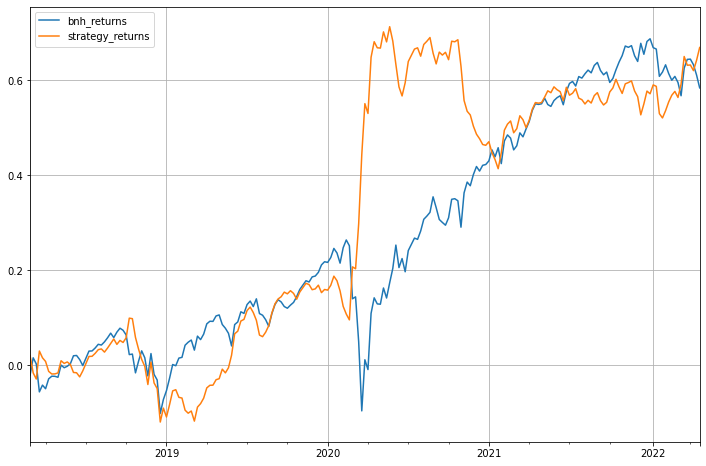

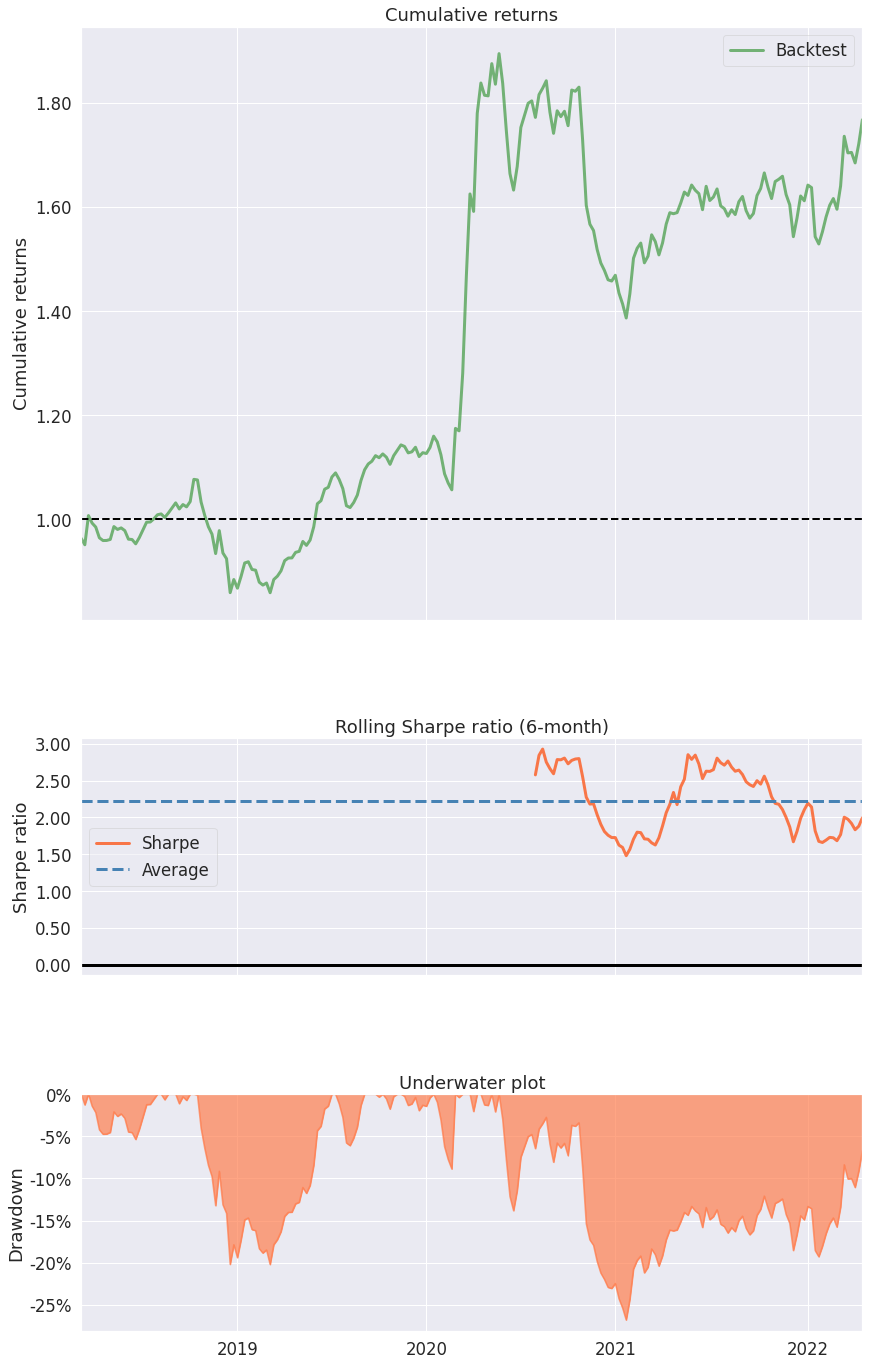

In [574]:
backtest_price(pd.concat([lagged_set[[focus]],signals_central_df>0],axis=1))

,signal
0,
2017-10-13,-0.007830
2017-10-20,0.015469
2017-10-27,0.007196
2017-11-03,-0.000977
2017-11-10,-0.003441
...,...
2022-03-25,0.013393
2022-04-01,1.061631
2022-04-08,-0.002729


In [ ]:
#setup[[focus]].loc[train[t]].pct_change()

In [ ]:
"""
final_spy_set = spy_set[['rf','rf_lag']]
final_spy_set.index = [s for s in final_spy_set['rf'].values.ravel()]

print(final_spy_set['rf_lag'].loc[[c for c in spy_cv_test.columns[1:]]])
backtest_price(pd.concat([y,np.sum(X*results.params,axis=1)],axis=1))
"""

In [ ]:
sectors_indexes_correlations = pd.DataFrame([n for n in np.concatenate(_outer_corrs)],columns=[['lf','rf','rf_lag','pct_sig','corr_dir']])
#sectors_indexes_correlations
pd.DataFrame([float(n[0]) for n in sectors_indexes_correlations['pct_sig'].values]).hist()
sectors_indexes_correlations = sectors_indexes_correlations.loc[pd.DataFrame([float(n[0]) for n in sectors_indexes_correlations['pct_sig'].values]).sort_values(by=0,ascending=False).index]


In [ ]:
#plot_returns(npa_true[vox_corrs_items[0]])

In [ ]:
#clientFunction(findMaxCorr,npa_true[0:1600])

In [ ]:
#results_corrs_true = clientFunction(findMaxCorr,sample(npa_true,200))
results_corrs_true = clientFunction(findMaxCorr,npa_true)
len(results_corrs_true)

#results_corrs_false = clientFunction(findMaxCorr,sample(npa_false,2000))
results_corrs_false = clientFunction(findMaxCorr,npa_false)
len(results_corrs_false)

In [ ]:
print('returns')
positives = [[x[0],x[1],x[2],x[3]] for x in results_corrs_true if (x[4] == 'positive')]

plt.plot(np.sort([p[3] for p in positives]))
positives = [[x[0],x[1],x[2],x[3]] for x in positives if ((x[3] > (.1+.3)/2))]
plt.show()

negatives = [[x[0],x[1],x[2],x[3]] for x in results_corrs_true if (x[4] == 'negative')]
#print(np.max([n[3] for n in negatives]))
plt.plot(np.sort([p[3] for p in negatives]))
plt.show()
negatives = [[x[0],x[1],x[2],x[3]] for x in negatives if (x[3] > (.1+.3)/2) & (x[2] > 0)]

for m in [*np.array(pd.DataFrame(np.array([*negatives,*positives]),columns=['f1','f2','lag','pct_sig']).sort_values(by='pct_sig',ascending=False))]:
    plot_returns(m,return_=True)
#print('nominal')
#for m in [*np.array(pd.DataFrame(np.array([*negatives,*positives]),columns=['f1','f2','lag','pct_sig']).sort_values(by='pct_sig',ascending=False))]:
#    plot_returns(m,return_=False)        

In [ ]:
#print('nominal')
positives = [[x[0],x[1],x[2],x[3]] for x in results_corrs_false if (x[4] == 'positive')]

plt.plot(np.sort([p[3] for p in positives]))
plt.show()
positives = [[x[0],x[1],x[2],x[3]] for x in positives if ((x[3] > (.525+1)/2))]


negatives = [[x[0],x[1],x[2],x[3]] for x in results_corrs_false if (x[4] == 'negative')]
#print(np.max([n[3] for n in negatives]))
plt.plot(np.sort([p[3] for p in negatives]))
plt.show()
negatives = [[x[0],x[1],x[2],x[3]] for x in negatives if (x[3] > (.525+1)/2) & (x[2] > 0)]
#for m in [*np.array(pd.DataFrame(np.array([*negatives,*positives]),columns=['f1','f2','lag','pct_sig']).sort_values(by='pct_sig',ascending=False))]:
#    plot_returns(m,return_=False)
print('returns')    
for m in [*np.array(pd.DataFrame(np.array([*negatives,*positives]),columns=['f1','f2','lag','pct_sig']).sort_values(by='pct_sig',ascending=False))]:
    plot_returns(m,return_=True)    

In [ ]:
#np.sum((setup['BZ=F'].pct_change()*setup['DCOILBRENTEU'].shift(1).pct_change())>0)/len(setup)

In [ ]:
#plt.plot(setup['BZ=F'].pct_change(4).corr(setup['DCOILBRENTEU'].shift(1)))

In [ ]:
#plot_returns(findMaxCorr(npa_true[146]))

In [ ]:
"""
pd.DataFrame(p_sigs_outer).hist()

vals,counts = np.unique(np.round(p_sigs,2), return_counts=True)
index = np.argmax(counts)
vals[index]
"""

In [ ]:
pd.concat([y,X.iloc[:,1:]],axis=1).corr().style.applymap(highlight_cells,threshold=crit_r(X)[0])



In [ ]:
final_spy_set = spy_set[['rf','rf_lag']]
final_spy_set.index = [s for s in final_spy_set['rf'].values.ravel()]

print(final_spy_set['rf_lag'].loc[[c for c in spy_cv_test.columns[1:]]])
backtest_price(pd.concat([y,np.sum(X*results.params,axis=1)],axis=1))

In [ ]:
warnings.filterwarnings('ignore')
backtest_pos([setup[['DGORDER', 'NFCI']],3])

In [ ]:
warnings.filterwarnings('ignore')
#randome luck
backtest_neg([setup[['VFH', 'VPU']],1])

In [ ]:
warnings.filterwarnings('ignore')
backtest_pos([setup[['VFH', 'ZO=F']],2])

In [ ]:
warnings.filterwarnings('ignore')
backtest_pos([setup[['MDYG', 'SB=F']],2])

In [ ]:
#np.cumsum(setup[['DGORDER']].pct_change())

In [ ]:
#client.close()

results = clientFunction(backtest,npa)

pd.DataFrame(results).hist()

In [ ]:
df_ = pd.merge(completed_fred_pvt, df, left_index=True, right_index=True)

In [ ]:
#completed_fred_pvt_df = completed_fred_pvt.asfreq('D').reindex(nyse_dates.index).interpolate(method='time')
completed_fred_pvt_df = completed_fred_pvt

temp_new = completed_fred_pvt.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates.index)
temp_dates = pd.date_range(completed_fred_pvt.index[0].strftime('%Y-%m-%d'), completed_fred_pvt.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
nyse_inbetween_temp_dates = nyse_dates.index[(nyse_dates.index >= temp_dates[0]) & (nyse_dates.index <= temp_dates[-1])]
temp_new = temp_new.reindex(nyse_inbetween_temp_dates)

completed_fred_pvt_df = temp_new
completed_fred_pvt_df.columns = [name[1] for name in completed_fred_pvt_df.columns]

np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))]

In [ ]:
n_ahead = 13

cv_inner = TimeSeriesSplit(n_splits=10,test_size=n_ahead)
cv_outer = TimeSeriesSplit(n_splits=11,test_size=n_ahead)


In [ ]:

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def print_color(t):
    print(t)
    display(html_print(' '.join([cstr(ti, color=ci) for ti,ci in t])))


In [ ]:
def findknee(xdata):
    rate_of_change=(xdata[0]-xdata[-1])/(len(xdata)-1)
    #print(rate_of_change)
    delta = xdata-xdata[-1]
    deltas = []
    deltas.append(delta[0])
    for d in range(1,len(xdata)):
        deltas.append(deltas[d-1]-rate_of_change)
    #print(deltas)
    for d in range(0,len(xdata)):
        deltas[d]=delta[d]-deltas[d]
    return(np.round(np.abs(deltas)))

def deriveANOVA(clf, df):

    labels = clf.labels_
    clusters = clf.n_clusters
    centers = clf.cluster_centers_
        
    within_ss = []

    for n in range(0,clusters):
      #WSS means the sum of distances between the points and the corresponding centroids for each cluster
      data = df[labels==(n)]
      within_ss.append(((data - centers[n])**2).sum(1).sum())

    WSS = total_within_ss = np.sum(within_ss)

    print('wss',total_within_ss)

    #sum of ((deviation from variable means) squared)
    tot_ss = np.sum(np.sum((df-df.mean())**2))
    print('tot_ss',tot_ss)

    cluster_BSS = []
    for n in range(0,clusters):
      #sum((variable/column means cluster - variable/column means data)^2)*len(cluster members)
      BSS = np.sum((df[labels==(n)].mean()-np.array(np.mean(df)))**2)*len(df[labels==(n)])
      cluster_BSS.append(BSS)

    BSS = np.sum(cluster_BSS)
    print('bss',BSS)
    
    return(tot_ss, BSS, within_ss)

def findOptimalK_ANOVA(df, mink=2, maxk=6, init_min=2, init_max=5):

    tss = []
    bss = []
    wss = []

    for k in range(mink,maxk):
        print(k)

        print(max(init_min,k+1))
        size_min_ = max(init_min,k+1)
        size_max_ = max(np.ceil(len(df)/k),init_max)
        if(size_min_>size_max_):
            break
        else:
            clf = KMeansConstrained(n_clusters=k, size_min=size_min_, size_max=size_max_, init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=int(time.time()), copy_x=True, n_jobs=4)
            clf.fit_predict(np.array(df))

            tot_ss, BSS, within_ss = deriveANOVA(clf, df)

            wss.append(within_ss)
            tss.append(tot_ss)
            bss.append(BSS)

    return(tss, bss, wss)

In [ ]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total


In [ ]:
"""
def highlight_cells(val, color_if_true, color_if_false, threshold_):
    color = color_if_true if float(val) >= threshold_ else color_if_false
    return 'background-color: {}'.format(color)
"""


def highlight_cells(val,threshold=0):
    color = 'green' if abs(val) > threshold else ''
    return 'background-color: {}'.format(color)


In [ ]:
def derive_fb_test_error(npa):
    n_ahead = 13

    subset_train = npa[0]
    subset_test = npa[1]

    base_model = Prophet()

    prophet_df_base = subset_train['Adj Close'].reset_index()#data.reset_index()
    prophet_df_base.columns = ['ds','y']
    prophet_df_base['y'] = np.log(prophet_df_base['y'])

    base_model.fit(prophet_df_base)

    future_base = base_model.make_future_dataframe(periods = n_ahead,freq='W-'+subset_train.index[-1].strftime('%a'))

    forecast_base = base_model.predict(future_base).set_index('ds')[['yhat','yhat_lower','yhat_upper']]
    df_pred_base = np.exp(forecast_base)

    rmse_ = mean_squared_error(subset_test['Adj Close'].tail(n_ahead), df_pred_base['yhat'].tail(n_ahead), squared=True)
    return([[subset_test['Adj Close'].tail(n_ahead)],[df_pred_base['yhat'].tail(n_ahead)],rmse_])

In [ ]:
"""
symbol_ = 'BA'

if(str(symbol_)=='None'):
    run=False
else:
    run=True

if(run):
    client = Client('192.168.3.100:8786')
    #client = Client(n_workers=4,threads_per_worker=1)

    s = symbol_
    msize = 2
    date_form = DateFormatter("%Y-%m-%d")

    metrics_df_ = pd.DataFrame(pd.DataFrame(screener_sorted.loc[s]).T[['volume_factor','Adj Close','adf','hurst']])
    subset=prices_df[prices_df['Symbol']==s]
    
    y = subset['Adj Close']
    data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W-'+subset.index[-1].strftime('%a'))
"""

In [ ]:
sequences = split_sequence(range(1,127),127-(13+10),13)
a=1
for s in range(0,len(sequences[0])):
    
    print("set:",a)
    sequences2 = split_sequence(range(1,len(sequences[0][s])),127-(13+10)*2,13)
    for s_ in range(0,len(sequences2[0])):
        #print("train")
        print((sequences2[0][s_]))
        #print("inner valid")
        print((sequences2[1][s_]))
    print("outer test")
    print((sequences[1][s]))
    a=a+1
        
    

In [ ]:

def plot_(symbols):

    #symbols = ['ITOS']
    #symbols = ['VPU']
    #symbols = ['MTRN']
    decision_metrics_df = pd.DataFrame()

    forecast_winners_df = pd.DataFrame()

    for symbol_ in symbols:

        print(symbol_)
        if(str(symbol_)=='None'):
            run=False
        else:
            run=True

        if(run):
            client = Client('192.168.3.100:8786')
            #client = Client(n_workers=4,threads_per_worker=1)

            s = symbol_
            msize = 2
            date_form = DateFormatter("%Y-%m-%d")

            metrics_df_ = pd.DataFrame(pd.DataFrame(screener_sorted.loc[s]).T)#[['volume_factor','Adj Close','adf','hurst']])
            subset=prices_df[prices_df['Symbol']==s]

            #if less than 2 years of data.
            print(len(subset))
            process = True;
            if(len(subset)<512):
                process=False

            if(process):

                dates = []
                for t in subset.index.values:
                    d = pd.Timestamp(t).strftime('%Y-%m-%d')
                    dates.append(d)
                    dto = datetime.strptime(d, '%Y-%m-%d').date()

                old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
                new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
                x = new_ordinal    

                lookup_index_ = []

                labels = list()
                print("symbol:",s)

                symbol_sector = screener_sorted.loc[symbol_]['Sector Symbol']

                print("sector:",dict_sectors_reverse[symbol_sector])
                symbol_index = screener_sorted.loc[s]['Index Symbol']

                try:
                    matched_index_name = indexes.iloc[np.where(indexes['Symbol'].values==s)].index[0]
                except:
                    try:
                        matched_index_name = screener_sorted.loc[s]['Index Symbol']
                    except:
                        matched_index_name = "error"

                try:
                    print("Index:",dict_indexes[matched_index_name])
                except:
                    print("Index: no index")

                print("Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==s)]['volume_factor'][0])

                print("sector_50td_tvf_vel:",screener_sorted[screener_sorted.index==s]['sector_50td_tvf_vel'][0])
                print("risk trend factor:",screener_sorted.iloc[np.where(screener_sorted.index==s)]['50td_tvf_vel'][0])

                temp = pd.DataFrame(market_data.loc[s])
                print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

                last_date = pd.DataFrame(subset.iloc[-1][['50tdBOLD','50tdMA-TP','50tdBOLU']],index=[prices_df[prices_df['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]

                bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','50tdBOLD','50tdMA-TP','50tdBOLU','200tdSMA','200tdSDev']]).T
                bbands['200td_lower'] = bbands['200tdSMA']-bbands['200tdSDev']*2
                bbands['200td_upper'] = bbands['200tdSMA']+bbands['200tdSDev']*2

                bbands.index = [last_date]
                display(bbands)

                display(metrics_df_)

                mean_revert_flag = False

                if(metrics_df_['adf_50td'][0]<.05):
                    print("ADFuller H0 rejected @ .05, Mean Reverting TS")
                    if(bbands['Adj Close'][0]<bbands['200td_lower'][0]):
                        colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
                        print(colored_text)
                        mean_revert_flag = True
                    if(bbands['Adj Close'][0]<bbands['50tdBOLU'][0]):
                        colored_text = colored(255, 0, 0, "50 td Mean Reverting buy signal")
                        print(colored_text)
                        mean_revert_flag = True    

                l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', '30d_vol_2yr','50td_tvf_vel/linear','supply_trend_1yr'],index=['blue','green','red','orange','black','yellow'],columns=['legend'])

                r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])

                display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])        

                f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=False,figsize=(22,5))
                ax1.plot(subset['30d_vol_2yr'],color='orange')
                #plt.title('30d_vol_2yr')
                ax1.set_xticklabels(subset[['30d_vol_2yr']].dropna().index, rotation = 45)

                locator = matplotlib.dates.AutoDateLocator()
                formatter = matplotlib.dates.ConciseDateFormatter(locator)

                ax1.xaxis.set_major_locator(locator)
                ax1.xaxis.set_major_formatter(formatter)

                ax1.xaxis.set_major_formatter(date_form)

                ax2.plot(subset['50td_tvf_vel'],color='black')
                ax2.set_xticklabels(subset[['50td_tvf_vel']].dropna().index, rotation = 45)

                locator = matplotlib.dates.AutoDateLocator()
                formatter = matplotlib.dates.ConciseDateFormatter(locator)

                ax2.xaxis.set_major_locator(locator)
                ax2.xaxis.set_major_formatter(formatter)

                ax2.xaxis.set_major_formatter(date_form)

                ax3_ = ax3.twinx()
                ax5_ = ax5.twinx()        
                ax4_ = ax4.twinx()

                y = subset['Adj Close']

                def myfunc(x):
                    return slope * x + intercept

                slope, intercept, r, p, std_err = stats.linregress(x, y)

                mymodel = list(map(myfunc, x))

                ax3.plot(x, y,marker = '.',markersize=msize, color = 'b')
                ax3.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
                ax3.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
                ax3_.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')
                ax3.plot(x, mymodel, color = 'k')

                l = matplotlib.dates.AutoDateLocator()
                f = matplotlib.dates.ConciseDateFormatter(l)    

                ax3.set_xticklabels(ax3.get_xticks(), rotation = 45)

                locator = matplotlib.dates.AutoDateLocator()
                formatter = matplotlib.dates.ConciseDateFormatter(locator)

                ax3.xaxis.set_major_locator(locator)
                ax3.xaxis.set_major_formatter(formatter)
                ax3.xaxis.set_major_formatter(date_form)

                if(symbol_sector=='error'):
                    pass
                else:
                    if(np.sum(sectors['Symbol'].values==s)>0):
                        pass
                    else:
                        sector_subset = prices_df[prices_df['Symbol']==symbol_sector]
                        print("Sector Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==symbol_sector)]['volume_factor'][0])
                        print("Sector 50td_tvf_vel:",screener_sorted.iloc[np.where(screener_sorted.index==symbol_sector)]['sector_50td_tvf_vel'][0])
                        #ax3_.plot(x, (sector_subset['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
                        ax4.plot(x, (sector_subset['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
                        ax4.plot(x, (sector_subset['trailing_1yr_max']).iloc[-len(subset):],marker = '.',markersize=msize, color = 'g')
                        ax4.plot(x, (sector_subset['trailing_1yr_min']).iloc[-len(subset):],marker = '.',markersize=msize, color = 'r')
                        ax4_.plot(x, (sector_subset['supply_trend_1yr']).iloc[-len(subset):],marker = '.',markersize=msize,color='y',linestyle=(0, (3, 10, 1, 10)))
                        ax4.set_xticklabels(subset.dropna().index, rotation = 45)
                        ax4.xaxis.set_major_formatter(date_form)

                if(str(screener_sorted.loc[s]['Index Symbol'])!='nan'):
                    if(screener_sorted.loc[s]['Index Symbol']!='error'):
                        index_subset = prices_df[prices_df['Symbol']==screener_sorted.loc[s]['Index Symbol']]
                        print("Index Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==screener_sorted.loc[s]['Index Symbol'])]['volume_factor'][0])
                        #print("Index 50td_tvf_vel:",screener_sorted.iloc[np.where(screener_sorted.index==screener_sorted.loc[s]['Index Symbol'])]['50td_tvf_vel'][0])
                        ax5.plot(x, index_subset['Adj Close'].iloc[-len(subset):],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
                        ax5.plot(x, index_subset['trailing_1yr_max'].iloc[-len(subset):],marker = '.',markersize=msize, color = 'g')
                        ax5.plot(x, index_subset['trailing_1yr_min'].iloc[-len(subset):],marker = '.',markersize=msize, color = 'r')
                        ax5_.plot(x, index_subset['supply_trend_1yr'].iloc[-len(subset):],marker = '.',markersize=msize,color='y',linestyle=(0, (1, 10)))
                        ax5.set_xticklabels(index_subset.dropna().index, rotation = 45)
                        ax5.xaxis.set_major_formatter(date_form)

                plt.show()

                data = subset[['Adj Close']].asfreq('D').interpolate(method='time').asfreq('W-'+subset.index[-1].strftime('%a'))

                
                npa_rmse_inner = []

                for trainv_ix, test_ix in cv_inner.split(data.index):

                    npa_rmse_inner.append([data.iloc[trainv_ix],data.iloc[test_ix]])
                

                """
                x_y_sets = split_sequence(data.index,52*2,13)

                for s in random.sample(list(range(0,len(x_y_sets[0]))),32):
                    npa_rmse_inner.append([data.loc[x_y_sets[0][s]],data.loc[x_y_sets[1][s]]])    

                """
                npa_rmse_outer = []
                
                for trainv_ix, test_ix in cv_outer.split(data.index):

                    npa_rmse_outer.append([data.iloc[trainv_ix],data.iloc[test_ix]])        
                """
                for s in random.sample(list(range(0,len(x_y_sets[0]))),32):
                    npa_rmse_outer.append([data.loc[x_y_sets[0][s]],data.loc[x_y_sets[1][s]]])            
                """
                print("fbprophet next 13 weeks")

                #starting from next week

                future = client.map(derive_fb_test_error, npa_rmse_inner)        

                rmses_inner = []

                for f in as_completed(future):
                    if(f.status=="error"):
                        rmses_inner.append(np.nan)
                    else:
                        rmses_inner.append(f.result())

                rmses_inner_ = [t[2] for t in rmses_inner]
                rmse_ = [r for r in rmses_inner_]

                rmse_inner_flags = [np.nanmean(rmse_),np.nanstd(rmse_)]

                print("inner cv scores:")
                inner_rmse_df = pd.DataFrame([rmse_inner_flags],columns=['mean','std'])

                scores = inner_rmse_df['mean'].values
                sdevs = inner_rmse_df['std'].values
                print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

                future = client.map(derive_fb_test_error, npa_rmse_outer)
                results_rmses_outer = []

                for f in as_completed(future):
                    if(f.status=="error"):
                        results_rmses_outer.append([np.nan])
                    else:
                        results_rmses_outer.append(f.result()) 

                results_rmses_outer_ = [t[2] for t in results_rmses_outer]
                test_score_mean = np.nanmean([r for r in results_rmses_outer_])
                test_score_std = np.nanstd([r for r in results_rmses_outer_])

                client = Client('192.168.3.100:8786')

                y_s = [t[0] for t in results_rmses_outer]
                y_hats = [t[1] for t in results_rmses_outer]
                test_errors_ = np.array(y_s)-np.array(y_hats)
                np.std(test_errors_,axis=0)
                std_resid = test_errors_/((np.sum(test_errors_)**2)/(len(test_errors_)-2)**.5)

                std_error_test = np.std(test_errors_,axis=0)

                print("test cv mean error, stdev (10 folds):",test_score_mean,test_score_std)

                m = Prophet(interval_width=0.95)

                prophet_df = data['Adj Close'].reset_index()#data.reset_index()
                prophet_df.columns = ['ds','y']
                prophet_df['y'] = np.log(prophet_df['y'])
                m.fit(prophet_df)

                future_ = m.make_future_dataframe(periods = n_ahead,freq='W-'+nyse_dates.index[-1].strftime('%a'))

                forecast = m.predict(future_).set_index('ds')[['yhat','yhat_lower','yhat_upper']]
                df_pred = np.exp(forecast)

                #fb forecast
                temp_df = pd.DataFrame(data['Adj Close']).reset_index()
                temp_df.columns = ['ds','Adj Close']
                temp_df.set_index('ds',inplace=True)

                s_date = df_pred.tail(n_ahead).index[np.argmax(df_pred['yhat'].tail(n_ahead).values)].strftime('%Y-%m-%d')

                print("sell date:",s_date)
                e_return = np.array((np.max(df_pred['yhat'].tail(n_ahead).values)-metrics_df_['Adj Close'])/metrics_df_['Adj Close'])[0]
                p_metrics = pd.DataFrame(df_pred.tail(n_ahead).iloc[np.argmax(df_pred['yhat'].tail(n_ahead).values)]).T
                print("expected return:",e_return)

                days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
                try:
                    discounted_return = (1+e_return)**(1/days_delta)-1
                except:
                    discounted_return = 0
                qtr_return = (1+discounted_return)**92

                print("discounted return:",discounted_return)
                print("quarter return:",qtr_return)

                #95% 2 tail
                t_score = stats.t.ppf(1-0.025, len(test_errors_))

                prediction_interval_yhat_upper = df_pred[['yhat']].tail(n_ahead)+(std_error_test.reshape(n_ahead,1)*t_score)
                prediction_interval_yhat_lower = df_pred[['yhat']].tail(n_ahead)-(std_error_test.reshape(n_ahead,1)*t_score)

                cv_outter_std_ratio = test_score_std / e_return
                cv_outter_err_ratio = test_score_mean / e_return                        

                stop_loss_price = pd.DataFrame(np.mean(pd.concat([df_pred[['yhat']].tail(n_ahead),prediction_interval_yhat_lower],axis=1),axis=1)).iloc[0].values[0]
                decision_metrics_df_ = pd.DataFrame([s,e_return,discounted_return,qtr_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['yhat_upper'].values[0],p_metrics['yhat_lower'].values[0]])#,columns=)#,index=[s_])#.sort_values(by='disc_rtn',ascending=False,inplace=True)
                decision_metrics_df_ = decision_metrics_df_.T
                decision_metrics_df_.columns=['SYMBOL','exp_return','discounted_return','qtr_return','sell_date','stop_loss_price','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_abs_err_n11','outer_cv_std_n11','mean_revert_flag','yhat_upper','yhat_lower']
                decision_metrics_df_.index = [symbol_]       

                bbands_ = bbands[set(bbands.columns).difference(['Adj Close'])]
                bbands_.index = [symbol_]

                outer_cv_avg_abs_err_n11_ratio = pd.DataFrame(test_score_mean/screener_sorted.loc[symbol_]['Adj Close'],columns=['outer_cv_avg_abs_err_n11_ratio'],index=[symbol_])
                outer_cv_std_n11_ratio = pd.DataFrame(test_score_std/screener_sorted.loc[symbol_]['Adj Close'],columns=['outer_cv_std_n11_ratio'],index=[symbol_])


                decision_metrics_df_ = pd.concat([decision_metrics_df_,bbands_,metrics_df_[metrics_df_.columns.difference(['50tdBOLD', '50tdMA-TP', '50tdBOLU','200tdSMA', '200tdSDev'])],outer_cv_avg_abs_err_n11_ratio,outer_cv_std_n11_ratio],axis=1)
                #decision_metrics_df_ = decision_metrics_df_.sort_values(by='exp_return',ascending=True)                        

                print("Outer CV Error / Price Ratio",decision_metrics_df_['outer_cv_avg_abs_err_n11_ratio'])
                print(" Outer CV StdDev / Price Ratio",decision_metrics_df_['outer_cv_std_n11_ratio'])

                decision_metrics_df = pd.concat([decision_metrics_df,decision_metrics_df_],axis=0)            

                savePlot=False
                if(decision_metrics_df_['outer_cv_avg_abs_err_n11_ratio'].values[0]<.9):
                    if(decision_metrics_df_['outer_cv_std_n11_ratio'].values[0]<.9):
                        if(decision_metrics_df_['qtr_return'].values[0]>1.089):
                            forecast_winners_df = pd.concat([forecast_winners_df,decision_metrics_df_],axis=0)
                            savePlot=True                 

                plt.plot(temp_df)
                plt.plot(df_pred)
                plt.legend(['Adj Close','yhat','yhat_lower','yhat_upper'],loc=2)
                plt.xticks(rotation = 45,size=8)

                if(savePlot):
                    plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_'+symbol_+'_full_forecast.png', dpi=300, format='png', bbox_inches='tight')           
                plt.show()

                plt.plot(temp_df.tail(n_ahead))
                plt.plot(df_pred.tail(n_ahead*2))
                plt.plot(prediction_interval_yhat_upper,linestyle = 'dashed')
                plt.plot(prediction_interval_yhat_lower,linestyle = 'dashed')

                plt.legend(['Adj Close','yhat','yhat_lower','yhat_upper','pi_upper','pi_lower'],loc=2)

                plt.xticks(rotation = 45,size=8)

                if(savePlot):
                    plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_'+symbol_+'_13w_forecast.png', dpi=300, format='png', bbox_inches='tight')
                plt.show()

                fcst = m.predict(future_)
                fig = m.plot(fcst)

                if(savePlot):
                    plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_'+symbol_+'_fb_sim_forecast.png', dpi=300, format='png', bbox_inches='tight')
                plt.show()            

                if(np.sum(np.array(fundamental_entries)==s)>0):
                    loc = np.where(np.array(fundamental_entries)==s)[0][0]
                    for item in fundamentals_quarterlies[loc][1]:
                        if(type(item[1]) == type(None)):
                            pass
                        else:
                            if(len(item[1])>0):
                                #print(len(item[1]))
                                #print(item)
                                print(item[0])
                                #with pd.option_context('display.precision', 2):
                                    #display(format_vertical_headers(pd.DataFrame(item[1]).T.sort_index(ascending=True)))
                                display(pd.DataFrame(item[1]).sort_index(ascending=True))
                client.close()

    decision_metrics_df.sort_values(by='exp_return',ascending=False,inplace=True) 

    #V.dump(techniqueUsed = end.strftime('%Y-%m-%d')+'_FBProphet', filename = 'fbpropet_metrics.xlsx', message = "FBProphet", version =1)
    decision_metrics_df.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.csv')
    forecast_winners_df.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_forecast_winners_df.csv')

    display(decision_metrics_df)



In [ ]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [ ]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [ ]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [ ]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [ ]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*indexes['Symbol'],*sectors['Symbol']]:
    subset = prices_df[prices_df['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate(method='time').asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [ ]:
sector_performance_Q_smoothed_return.columns = [*[i for i in indexes.index],*[v for v in sectors.index]]
sector_performance_return.columns = [*[i for i in indexes.index],*[v for v in sectors.index]]

In [ ]:
"""
from scipy import stats as st
from scipy.stats import t

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

warnings.filterwarnings('ignore')
for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 

display(B.style.apply(b_g,cmap=cm))

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5

print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]/np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)

display(p_values.style.applymap(highlight_cells, color_if_true='green', color_if_false='yellow', threshold_=.5))

p_values.hist()
"""

In [ ]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"..\data\\interim\\Business cycles.png"
display(Image.open(path))
path=r"..\data\\interim\\Business Cycles-2.png"
display(Image.open(path))

In [ ]:
sector_performance_returned_no_dup = sector_performance_return.loc[~sector_performance_return.index.duplicated(keep ='first')]
sector_performance_return_pvt = sector_performance_returned_no_dup[sector_performance_returned_no_dup.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_returned_no_dup.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_returned_no_dup.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_returned_no_dup.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    
A = sector_performances_values
B = sector_performance_returned_no_dup.T

df = B.style.apply(b_g,cmap='RdYlGn')

display(df)


In [ ]:
"""
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
display(df_sea_adj)
"""

In [ ]:
"""
index_performance = []
for v in indexes['Symbol'].values:
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_i = pd.DataFrame(index_performance,index=indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted
"""

In [ ]:
"""
sector_performance = []
for v in sectors['Symbol'].values:
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_v = sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted
"""

In [ ]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in indexes.index],*[v for v in sectors.index]],loc=2,fontsize=7)
plt.show()

In [ ]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


In [ ]:
"""
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()
"""

In [ ]:
#risk_trend_threshold

In [ ]:
#market_data['sector'] = stock_fundamentals['sector']

In [ ]:
#screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [ ]:
#len(screener)

In [ ]:
#prices_df.columns

In [ ]:
#threshold

In [ ]:
#threshold_value = summary.dropna()['risk_trend_factor'].quantile([threshold])

In [ ]:
threshold = 1

In [ ]:
screener_sorted.columns

In [ ]:
fred_pvt_sample = completed_fred_pvt_df[fred_names].asfreq('D').interpolate(method='time').asfreq('Q').dropna()

In [ ]:
tvv_50td_filter = screener_sorted['50td_tvf_vel'].replace(['missing','missingmissing','error'], np.nan).dropna()
tvv_50td_filter = tvv_50td_filter[tvv_50td_filter>np.max([tvv_50td_filter.median(),tvv_50td_filter.mean()])]

tvv_20td_filter = screener_sorted['20td_tvf_vel'].replace(['missing','missingmissing','error'], np.nan).dropna()
tvv_20td_filter = tvv_50td_filter[tvv_20td_filter>np.max([tvv_20td_filter.median(),tvv_20td_filter.mean()])]

risk_trend_factor_filter = screener_sorted['risk_trend_factor'].replace(['missing','missingmissing','error'], np.nan).dropna()
risk_trend_factor_filter = risk_trend_factor_filter[risk_trend_factor_filter>np.max([risk_trend_factor_filter.median(),risk_trend_factor_filter.mean()])]

filtered = np.unique([*tvv_50td_filter.index,*tvv_20td_filter.index, *risk_trend_factor_filter.index])

filtered = set(risk_trend_factor_filter.index).intersection(set(tvv_50td_filter.index).intersection(tvv_20td_filter.index))

filtered = screener_sorted.loc[filtered][['50td_tvf_vel','20td_tvf_vel','risk_trend_factor']]
filtered = (filtered>filtered.median()).all(axis=1)
filtered = filtered[filtered].index

#filtered = screener_sorted.loc[filtered][['50td_tvf_vel','20td_tvf_vel','risk_trend_factor']]
#filtered = filtered[filtered>np.max([filtered.median()])]
print(len(filtered))

In [ ]:
filtered_screener_sorted = screener_sorted.loc[filtered]

In [ ]:
len(filtered_screener_sorted)

In [ ]:

with localconverter(ro.default_converter + pandas2ri.converter):
      r_from_pd_df = ro.conversion.py2rpy(fred_pvt_sample.melt(ignore_index=False).reset_index().rename(columns={'index': 'Date'}))


In [ ]:
#ro.X11()
#ro.windows()
ro.r('''

my_mean <- function(x, na.rm=TRUE) {
  mean(x, na.rm = na.rm)
}

f <- function(y) {
#print(y)

#library(arfima)
#varvefd = arfima(y)
#d = summary(varvefd)$coef[[1]][1]
#return(d)

tsfeature_tbl <- y %>%
group_by(variable) %>%
tk_tsfeatures(
  .date_var = Date,
  .value    = value,
  .period   = 4,
  .features = c("frequency", "stl_features", "entropy", "acf_features", "my_mean"),
  .scale    = TRUE,
  .prefix   = "ts_"
) %>%
ungroup()
    
print(tsfeature_tbl)

set.seed(123)

cluster_tbl <- tibble(
    cluster = tsfeature_tbl %>% 
        select(-variable) %>%
        as.matrix() %>%
        kmeans(centers = 7, nstart = 100) %>%
        pluck("cluster")
) %>%
    bind_cols(
        tsfeature_tbl
    )

cluster_tbl

cluster_tbl %>%
    select(cluster, variable) %>%
    right_join(y, by = "variable") %>%
    group_by(variable) %>%
    plot_time_series(
      Date, value, 
      .color_var   = cluster, 
      .facet_ncol  = 2, 
      .interactive = FALSE
    )
plot(cluster_tbl)

return(tsfeature_tbl)
}
''')
grdevices.png(file="..\\reports\\figures\\cluster_tbl.png", width=4096, height=1024)
r_f = ro.globalenv['f']

d=ro.conversion.rpy2py((r_f(ro.conversion.py2rpy(r_from_pd_df))))

#rprint(pp)

time.sleep(3)
#grdevices.dev_copy(device = r.png, filename = "plot.png", width = 1000, height = 500)
grdevices.dev_off()

#From here optional, if you want a waiting time
#Elsewise close the plot manually afterwards with grdevices.dev_off()

#grdevices.dev_off()
#grdevices.dev_off()


In [ ]:
pca = PCA(n_components=0.99, svd_solver='full')

X = np.array(d.iloc[:,1:])

pca.fit(scale(X))
#pca.explained_variance_
pca.explained_variance_ratio_.cumsum()
X_pca = pd.DataFrame(pca.transform(d.iloc[0:,1:]))
X_pca.index = d.index
X_pca.sort_values(by=[0],ascending=False,inplace=True)

TSS_ = []
BSS_ = []
WSS_ = []
silhouettes_ = []

for k in range(2,int(len(d)/2)):
    model = KMeans(n_clusters=k, random_state=0, n_init=100).fit(X)
    #print(model.inertia_)

    codebook = np.array(model.cluster_centers_)
    partition, euc_distance_to_centroids = vq(X, codebook)
    WSS = np.sum(euc_distance_to_centroids**2)
    
    silhouette_avg = silhouette_score(X, model.labels_)

    silhouettes_.append(silhouette_avg)
    
    TSS = np.sum((X-X.mean(0))**2)

    BSS = TSS - WSS

    TSS_.append(TSS)
    BSS_.append(BSS)
    WSS_.append(WSS)
    
    #print(TSS, WSS, BSS)


In [ ]:

init_min = 2
init_max = 5


mink = 2
maxk = 6

tss, bss, wss = findOptimalK_ANOVA(X_pca, mink = mink, maxk = maxk)

In [ ]:
plt.plot(np.array(BSS_)/np.array(TSS_))
plt.show()
plt.plot(np.array(WSS_))
plt.show()
plt.plot(np.array(silhouettes_))
plt.show()



In [ ]:

bss_ = findknee(bss)
bss_ = bss_/np.max(bss_)

wss_ = findknee(np.array(pd.DataFrame(wss).mean(1)))
wss_ = wss_/np.max(wss_)

temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)
temp_df.index = np.array(range(0,len(wss_)))+mink
#plt.plot(temp_df)

set_ = np.abs(temp_df-1)
plt.plot(set_)

optimal_k = np.argmin(set_)+mink
plt.plot(abs(set_-1))
 
print(optimal_k)


In [ ]:
clf = KMeansConstrained(n_clusters=optimal_k, size_min=init_min, size_max=max(np.ceil(len(X_pca)/optimal_k),init_max), init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=None, copy_x=True, n_jobs=4)
clf.fit_predict(X_pca)

labels = clf.labels_
clusters = clf.n_clusters
centers = clf.cluster_centers_

print(labels)

tot_ss, BSS, within_ss = deriveANOVA(clf, X_pca)

Global_F = (BSS/(optimal_k-1))/(np.mean(within_ss)/(len(X_pca)-optimal_k))
global_sig = 1-f_.cdf(Global_F, (len(X_pca)-optimal_k), len(X_pca)-1)

ind_F_scores = []

for w in range(0,len(within_ss)):

    dfn = (optimal_k-1)
    dfd = np.sum(labels==w)-optimal_k

    F_score = (BSS/dfn)/(within_ss[w]/(dfd))
    ind_F_scores.append(F_score)

print("Global F:",Global_F)
print("Global Sig:",global_sig)
print("F-Scores:", ind_F_scores)

print("P-Scores:", 1-f_.cdf(ind_F_scores, dfn, dfd))

X_pca['cluster'] = labels

In [ ]:


cgram = Clustergram(range(1, 8))
cgram.fit(X_pca)
cgram.plot()
cgram

In [ ]:
"""
model = VARMAX(future_commodities_n_w_index_pvt_w_Fred_, order=(1,1,))
model_fit = model.fit(disp=False)
yhat = model_fit.forecast(13)
print(yhat)
"""

In [ ]:
prices_pvt = pd.pivot_table(prices_df, values=['Adj Close'], index=prices_df.index,columns='Symbol').asfreq('D').interpolate(method='time',limit_direction='forward',limit_area='inside').reindex(nyse_dates.index)
prices_pvt.index = [d.strftime('%Y-%m-%d') for d in prices_pvt.index]
prices_pvt.columns = prices_pvt.columns.droplevel(0)
prices_pvt.index = [pd.to_datetime(d) for d in prices_pvt.index]
combined_prices_w_commodities = prices_pvt.join(future_commodities_n_w_index_pvt_w_Fred.reindex(prices_pvt.index)).dropna()

In [ ]:

lengths = []
for i in range(0,max(X_pca['cluster'])+1):
    subset = d.loc[X_pca[X_pca['cluster']==i].index]
    lengths.append(len(subset))
    
colors = ['purple','cyan','magenta','green','red','black','pink','yellow','blue','brown','orange','grey']
my_cmap = LinearSegmentedColormap.from_list(
    'color_map', colors, N=max(lengths))

rescale = lambda y: (y - 0) / (np.max(lengths) - 0)    


In [ ]:

for i in range(0,max(X_pca['cluster'])+1):
    print("Group: ",i)
    subset = d.loc[X_pca[X_pca['cluster']==i].index]
    #
    for c_ in range(0,len(subset['variable'])):
        c = subset['variable'].values[c_]
        try:
            #print(dict_fred[c])
            display(html_print(' '.join([cstr(ti, color=ci) for ti,ci in ((dict_fred[c], colors[c_]),)])))

            #display(html_print(' '.join([cstr(ti, color=my_cmap(rescale(c_))) for ti in (('hello my name is'),)])))
            #print(colored("hello red world", my_cmap(rescale(c_))))
            if(c_==0):
                fig, ax1 = plt.subplots( figsize=(30,4))
                ax1.plot(fred_pvt_sample[c],color=my_cmap(rescale(c_)))
                ax1.get_yaxis().set_ticks([])
            else: 
                ax2 = ax1.twinx()
                ax2.plot(fred_pvt_sample[c],color=my_cmap(rescale(c_)))
                ax2.get_yaxis().set_ticks([])
        #ax1.legend(subset['variable'].values,loc=2)
        except:
            pass
    plt.show()

In [ ]:
filter_ = fred_pvt_sample.columns.tolist()
def f3(Y):
    
    #Y = x
    #output_slider_variable.value
    internalFilter = filter_.copy()
    internalFilter.remove(Y)
    all_data_ = pd.concat([fred_pvt_sample[Y],fred_pvt_sample[internalFilter]], axis=1)    
    #print(all_data_.describe())
    display(fred_pvt_sample.describe())
    #x_ticks = all_data_.index[np.arange(0, len(all_data.index), int(len(internalFilter)/5))]
    x_ticks  = []
    for index, element in enumerate(fred_pvt_sample.index):
        if index % int(np.round(len(fred_pvt_sample.index)/10)) == 0:
            x_ticks.append(element)
    plt.plot(fred_pvt_sample[Y])
    plt.xticks(x_ticks, rotation = 45)
    plt.show()        
    plt.hist(fred_pvt_sample[Y], bins='auto')
    plt.show()
    diff = pd.DataFrame((fred_pvt_sample[Y].pct_change())).dropna()
    plt.hist(diff, bins='auto')
    plt.show()
    return(fred_pvt_sample)
    
out = interactive(f3, Y=filter_)

#output_slider_variable.observe(f4, 'value')

print("choose Y")
display(out)


In [ ]:
print('nominal,','pct_change,','pct_change().cumsum')
for pos in range(0,len(fred_names)):
    print(fred_friendly_names[pos],fred_names[pos])
    name = fred_names[pos]
    
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(15,6))
    ax1.plot(completed_fred_pvt_df[name])
    ax1.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    ax2.plot(completed_fred_pvt_df[name].pct_change())
    ax2.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    ax3.plot(completed_fred_pvt_df[name].pct_change().cumsum())
    ax3.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    plt.show()

In [ ]:
#screener['vol_30d_2yr']

In [ ]:
#pd.DataFrame(np.mean(np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())[['mean','pi_lower']],axis=1)).iloc[0].values[0]
#[s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]]
#screener['Adj Close'].loc[decision_metrics_df.index]

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

#batchClearLimit = round(len(list__)/7)

print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*indexes['Symbol'].values,*sectors['Symbol'].values,"""
"""
widgets.Dropdown(
    #options=stocks_,
    #value=None,
    description='Choose Stock:',
    disabled=False,
)

#y_=widgets.Select(options=stocks_,disabled=False)
y_=widgets.Select(options=np.sort([*list_sector_n_indexes,*list_stocks]),value=None,disabled=False)

a=interact(plot_,symbol_=y_)
"""

In [ ]:
observer_set = [*[d for d in dict_sectors_reverse]][:-1]

In [ ]:

df = prices_df[prices_df['Symbol']=='SPY'][['Adj Close']].asfreq('D').interpolate(method='time').asfreq('W-'+end.strftime('%a')).reset_index()
df.columns = ['ds','y']

m = Prophet()
#m = MultiProphet(columns=observer_set)

for o in observer_set:
    temp = prices_df[prices_df['Symbol']==o][['Adj Close']].asfreq('D').interpolate(method='time').asfreq('W-'+end.strftime('%a')).reset_index()[['Adj Close']]
    temp.columns = [o]
    
    df = pd.concat([df,temp],axis=1)
    
#plt.plot(df['y'])

m.fit(df[['ds','y']])
future_ = m.make_future_dataframe(periods = 14,freq='W-'+nyse_dates.index[-1].strftime('%a')).tail(13)

forecast = m.predict(future_).set_index('ds')[['yhat','yhat_lower','yhat_upper']]

m.plot(forecast.reset_index())

In [ ]:
#VARMAX

dates = [pd.to_datetime(d).value for d in df['ds']]
dates = np.array(dates)-np.array(dates[0])/10**11
dates=dates-dates.min()
dates = [int((d/10**11)/32) for d in dates]

orders = []
for p in range(1,13):
    for q in range(1,13):
        orders.append([p,q])

        
#cnn reqs #s
df2 = df.copy()
df2['ds'] = dates

df2.index=[pd.Timestamp(d).strftime('%Y-%m-%d') for d in df['ds'].values]


In [ ]:
#VARMAX


quarterly_13_index = []
for i in range(df.index[0],df.index[-1],13):
    quarterly_13_index.append(i)
    
#add delta of last two records
quarterly_13_index = np.array(quarterly_13_index) + df.index[-1]-quarterly_13_index[-1]  

"""
for o in orders:
    model = VARMAX(df2,order=o)
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(n_ahead)
    print(yhat)
"""

"""
from zca import zca
zca = zca.ZCA()
zca.fit(df.set_index('ds').iloc[quarterly_13_index])


model = VARMAX(zca.fit_transform(df.set_index('ds').iloc[quarterly_13_index]),order=(1,1))
model_fit = model.fit(disp=False)
yhat = model_fit.forecast(n_ahead)        
"""

In [ ]:
df2.index

In [ ]:
#pd.concat([df_,fred_data])

In [ ]:
#df_ = df.iloc[quarterly_13_index]

fred_data = completed_fred_pvt_df.asfreq('d').interpolate(method='time')

#fred_data = fred_data.iloc[df_.index].dropna(axis=1, thresh = int(0.95*fred_data.shape[0]))
fred_data.index=[pd.Timestamp(d).strftime('%Y-%m-%d') for d in fred_data.index]

#combined_fred_sectors_sp500 = pd.concat([df2.iloc[quarterly_13_index],fred_data.loc[df2.iloc[quarterly_13_index].index]],axis=1)
combined_fred_sectors_sp500 = pd.concat([df2,fred_data.loc[df2.index]],axis=1)
"""
df_['ds'] = [int(d/32) for d in df_['ds']]
df_.columns

df_ = pd.concat([df_,fred_data],axis=1)
#df_ = df_.apply(np.log)
"""

In [ ]:
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='yeo-johnson')

def stable_sigmoid(x):

    sig = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return sig

def inverse_sigmoid(x):
    inv_sig = -np.log((1 / (x + 1e-8)) - 1)
    return inv_sig

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()

df_ = combined_fred_sectors_sp500

df_.dropna(axis=1, thresh = int(1*df_.shape[0]), inplace=True)
subset_df_ = df_[[
    'ds',
    'y',
    'VAW',
    'VOX',
    'VCR',
    'VDC',
    'VDE',
    'VFH',
    'VHT',
    'VIS',
    'VNQ',
    'VGT',
    'VPU',
    'DGS3MO',
    'DGS2',
    'DGS10'
    #'USALOLITONOSTSAM',
    #'BUSLOANS',
    #'CPIAUCSL'
]]

power.fit(np.array(subset_df_))

#from zca import zca
#from zca.zca import ZCA
#zca = zca.ZCA()
#from zca import ZCA

#trf = ZCA().fit(np.array(subset_df_))
#X_whitened = trf.transform(np.array(subset_df_))

#df_t = pd.DataFrame(X_whitened,columns=subset_df_.columns)

df_t = pd.DataFrame(stable_sigmoid(power.transform(np.array(subset_df_))),columns=subset_df_.columns)

In [ ]:
#future_commodities_n_w_index_pvt_w_Fred

In [ ]:

# multivariate multi-step encoder-decoder lstm example

 

#not used atm
# define input sequence
in_seq = []
for s in range(0,len(df_.columns)):
    in_seq.append([np.array(df_.iloc[:,[s]])])


In [ ]:
# multivariate multi-step stacked lstm example
# split a multivariate sequence into samples

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, 0:2], sequences[end_ix-1:out_end_ix, 1][1:3]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
     
# define input sequence


In [ ]:
#yhat

In [ ]:
#np.exp(np.log(10))

In [ ]:
#X_reconstructed = X_whitened)
#assert(np.allclose(X, X_reconstructed)) # True


In [ ]:

#import numpy as np
#X = np.random.random((10000, 15)) # data array
#trf = ZCA().fit(X)
#X_whitened = trf.transform(X)
#X_reconstructed = zca.inverse_transform(yhat[0][0][:-1].re.shape(1, -1))
#assert(np.allclose(X, X_reconstructed)) # True

In [ ]:
#plt.plot(df_.iloc[-1][1:n_features])
#plt.plot(yhat[0][-1])

In [ ]:
#pd.DataFrame(X[-1])

In [ ]:

"""
m = Prophet()
#m = MultiProphet(columns=observer_set)

for o in observer_set:
    temp = prices_df[prices_df['Symbol']==o][['Adj Close']].asfreq('D').interpolate(method='time').asfreq('W-'+end.strftime('%a')).reset_index()[['Adj Close']]
    temp.columns = [o]
    
    df = pd.concat([df,temp],axis=1)

for o in observer_set:
    m.add_regressor(o)
    
    
m.fit(df)

#have to have future values, pretty much multiple regression (find stationary (cv tested?) ccf lead/lag? values)
future_ = m.make_future_dataframe(periods = 14,freq='W-'+end.strftime('%a')).tail(13)
forecast = m.predict(pd.concat([df.set_index('ds')[observer_set],future_.set_index('ds')],axis=0).reset_index().dropna()).set_index('ds')

m.plot(forecast.reset_index())
    
#plt.plot(df['y'])
"""

In [ ]:
A = pd.pivot_table(prices_df, values=['Adj Close'], index=prices_df.index,columns=['Symbol']).asfreq('D').interpolate(method='time').asfreq('W-'+end.strftime('%a'))
A.columns = A.columns.droplevel(0)
A = A[[*sectors['Symbol'].values,*indexes['Symbol'].values]]
B = completed_fred_pvt_df[fred_names].asfreq('D').interpolate(method='time').asfreq('W-'+end.strftime('%a')).dropna()
#B.columns = B.columns.droplevel(0)
C = future_commodities_n_w_index_pvt_w_Fred.asfreq('D').interpolate().asfreq('W-'+end.strftime('%a'))
A.join(B).join(C).to_csv('..\\data\\processed\\weekly_stocks_w_fred_n_commodities.csv')

In [ ]:
len(filtered_screener_sorted)

In [ ]:
def process_values(values):
    
    sector_list = []
    symbol_list = []
    for i in np.array(values):
        t= dict_sectors[i]
        sector_list.append(t)
        
        sublist = filtered_screener_sorted[filtered_screener_sorted['Sector Symbol']==t].index
        temp_df = filtered_screener_sorted.loc[sublist]
        #temp_df_ = temp_df['risk_trend_factor'].replace(['error','missing'], np.nan).dropna()
        
        #temp_df_filtered = temp_df_[temp_df_>0]
        
        flat_list = [item for item in temp_df.index]
        symbol_list.extend(flat_list)        
    
    button = widgets.Button(description="Process")
    output = widgets.Output()

    display(button, output)

    print("Symbols > 1 (50td_tvf_vel + risk_trend_factor)")
    print(len(sector_list),sector_list)
    print(len(symbol_list),symbol_list)
    
    def on_button_clicked(b):
        with output:            
            plot_(symbol_list)

    button.on_click(on_button_clicked)    
    
    
y_=widgets.SelectMultiple(
    options=list(dict_sectors.keys()),
    description='Choose Sectors: ',
    disabled=False)

a=interact(process_values,values=y_)
    

In [ ]:
decision_metrics_df = pd.read_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.csv')
decision_metrics_df.set_index(decision_metrics_df.iloc[:, 0],inplace=True)

counts_df = pd.DataFrame(decision_metrics_df['Sector'].value_counts())

print(counts_df)
fig, ax = plt.subplots()
ax.pie(counts_df['Sector'], labels=counts_df.index)
ax.set_title('Sector Participartion > (50td_tvf_vel + risk_trend_factor) of 0')
plt.tight_layout()
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_piechart-sectors.png', dpi=300, format='png', bbox_inches='tight')

In [ ]:

prices_pvt_wk = pd.pivot_table(prices_df, values=['Adj Close'], index=prices_df.index,columns=['Symbol']).asfreq('d').interpolate(method='time').asfreq('W-'+nyse_dates.index[-1].strftime('%a'))
prices_pvt_wk.columns = prices_pvt_wk.columns.droplevel(0)


In [ ]:

c_df = prices_pvt_wk.corr()
c_df.sort_values(by='SPY',inplace=True,ascending=False,axis=1)
c_df.sort_values(by='SPY',inplace=True,ascending=False,axis=0)
c_df.to_csv('..\\reports\\'+end.strftime('%Y-%m-%d')+'_corr_5_yr_prices_pvt_wk.csv')

In [ ]:
"""
from vevestaX import vevesta as v

try:
    V=v.Experiment(speedUp = True)
    V.start()
    V.ds=decision_metrics_df
    V.fe=decision_metrics_df
    V.end()
    V.dump(techniqueUsed='fbprophet',filename='..\\reports\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.xlsx',message="EDA-fbprophet-nested-CV",version=1)
    os.rename('EDA.pdf','..\\reports\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.pdf')
    #os.remove('EDA.pdf')
except:
    pass

try:
    V=v.Experiment()
    V.start()
    V.ds=fred_pvt_sample
    V.fe=fred_pvt_sample
    V.end()
    V.dump(techniqueUsed='fred_data',filename='..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_fred_pvt.xlsx',message="EDA-fred",version=2)
    os.rename('EDA.pdf','..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_fred_pvt.pdf')
    
except:
    pass

try:
    V=v.Experiment()
    V.start()
    V.ds=prices_pvt_wk[filtered_screener_sorted.index]
    V.fe=prices_pvt_wk[filtered_screener_sorted.index]
    V.end()
    V.dump(techniqueUsed='price_data',filename='..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_prices_pvt_wk.xlsx',message="EDA-prices",version=3)
    os.rename('EDA.pdf','..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_prices_pvt_wk.pdf')
except:
    pass
"""
